#### Imports

In [ ]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras import metrics
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read in Data

Data is found at: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success. To read in the dataset below, please download the data and add it to the runtime files or your google drive. Please update google drive and filename when reading in the datafile.

In [ ]:
#update google drive path as needed
d = pd.read_csv('/content/drive/MyDrive/DS207/data/final project/dataset.csv')

#update filename as needed
# d = pd.read_csv('dataset.csv')
d.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Data Cleaning

In [ ]:
# Correct column names
d.rename(columns = {'Nacionality':'Nationality', 'Target': 'Student Status'}, inplace = True)

# Copy data set
df = d.copy()

# Change student status column to numeric in original data set
d['Student Status'] = d['Student Status'].map({'Dropout' : 0, 'Enrolled': 1, 'Graduate': 2})

# Get all categorical variables except Student status
cat_cols = ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance',
          'Previous qualification', 'Nationality', "Mother's qualification", "Father's qualification",
          "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor',
          'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']

# Get all continuous variables.
cont_cols = ['Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
             'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
             'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
             'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
             'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
             'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)',
             'Unemployment rate', 'Inflation rate', 'GDP']

# Change categorical columns to category datatype.
df[cat_cols] = df[cat_cols].astype('category')

# Replace 0 and 1 values with Female and Male respectively.
df = df.replace({'Gender': {0: 'Female', 1: 'Male'}})

# Replace numerical values with their verbal analogs.
df[['Nationality']] = df[['Nationality']].replace({'Nationality': {1: 'Portuguese', 2: 'German', 3: 'Spanish',
                                                               4: 'Italian', 5: 'Dutch', 6: 'English',
                                                               7: 'Lithuanian', 8: 'Angolan', 9: 'Cape Verdean',
                                                               10: 'Guinean', 11: 'Mozambican', 12: 'Santomean',
                                                               13: 'Turkish', 14: 'Brazilian', 15: 'Romanian',
                                                               16: 'Moldovan', 17: 'Mexican', 18: 'Ukrainian',
                                                               19: 'Russian', 20: 'Cuban', 21: 'Colombian'}})


# Find the optimal number of bins using Sturges’ rule.
bins = int(math.ceil(math.log2(len(df))) + 1)
age_min = df['Age at enrollment'].min()
age_max = df['Age at enrollment'].max()
bin_int = df['Age at enrollment'].max() // bins
bin_edges = [i for i in range(age_min, age_max + bin_int, bin_int)]

# Replace 1 - Single, 2 - Married, 3 - Widower, 4 - Divorced, 5 - Facto union, and 6 - Legally separated.
df = df.replace({'Marital status': {1: 'Single', 2: 'Married', 3: 'Widower', 4: 'Divorced',
                                    5: 'Facto union', 6: 'Legally separated'}})

# Replace 0 and 1 values with Evening and daytime respectively.
df = df.replace({'Daytime/evening attendance': {0: 'Evening', 1: 'Daytime'}})

df[['Course']] = df[['Course']].replace({'Course': {1: 'Biofuel Production Technologies', 2: 'Animation and Multimedia Design',
                                                    3: 'Social Service (evening attendance)', 4: 'Agronomy',
                                                    5: 'Communication Design', 6: 'Veterinary Design',
                                                    7: 'Informatics Engineering', 8: 'Equiniculture', 9: 'Management',
                                                    10: 'Social Service', 11: 'Tourism', 12: 'Nursing', 13: 'Oral Hygiene',
                                                    14: 'Advertising and Marketing Management',
                                                    15: 'Journalism and Communication', 16: 'Basic Education',
                                                    17: 'Management (evening attendance)'}})

In [ ]:
df = df[df["Student Status"] != "Enrolled"]
df["Failed classes"] = (df['Curricular units 1st sem (approved)'] - df['Curricular units 1st sem (enrolled)']) * (df['Curricular units 2nd sem (approved)'] - df['Curricular units 2nd sem (enrolled)'])

# bin the age
tf.keras.backend.clear_session()
age = np.array(df['Age at enrollment'])
age_bins = [0.1, 18, 20, 22, 25, 35]
age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
df['age_binned']= age_binned

# combine parent qualifications
def parent_quals(mother_qual, father_qual):
  #0 - both parents completed high school (1)
  #1 - one parent completed high school (1)
  #2 - both parent have some degree of higher education (2-8 or 39-44)
  #3 - one parent has some higher education (2-8 or 39-44)
  #4 - both parents did not complete high school (9-29)
  #5 - one parent did not complete high school (9-29)
  #6 - both parents have very little education (30, 35-38)
  #7 - one parent has very little education (30, 35-38)
  #8 - one or more parents unknown

  # if multiple statuses overlap, choose the one with the highest education
  joint_qual = []
  mother_qual = np.array(mother_qual)
  father_qual = np.array(father_qual)
  for i in np.arange(0, len(mother_qual)):
    if ((mother_qual)[i] == 1 and father_qual[i]==1):
      joint_qual.append(0)
    elif(((mother_qual)[i] == 1 or father_qual[i]==1)):
      joint_qual.append(1)
    elif(((mother_qual[i] >= 2 and mother_qual[i]<=8) or (mother_qual[i] >= 39 and mother_qual[i]<=44)) and (father_qual[i] >= 2 and father_qual[i]<=8) or (father_qual[i] >= 39 and father_qual[i]<=44)):
      joint_qual.append(2)
    elif(((mother_qual[i] >= 2 and mother_qual[i]<=8) or (mother_qual[i] >= 39 and mother_qual[i]<=44)) or (father_qual[i] >= 2 and father_qual[i]<=8) or (father_qual[i] >= 39 and father_qual[i]<=44)):
      joint_qual.append(3)
    elif((mother_qual[i] >= 9 and mother_qual[i]<=29) and (father_qual[i] >= 9 and father_qual[i]<=29)):
      joint_qual.append(4)
    elif((mother_qual[i] >= 9 and mother_qual[i]<=29) or (father_qual[i] >= 9 and father_qual[i]<=29)):
      joint_qual.append(5)
    elif(((mother_qual[i] == 30) or (mother_qual[i] >= 35 and mother_qual[i]<=38)) and ((father_qual[i] == 30) or (father_qual[i] >= 35 and father_qual[i]<=38))):
      joint_qual.append(6)
    elif(((mother_qual[i] == 30) or (mother_qual[i] >= 35 and mother_qual[i]<=38)) or ((father_qual[i] == 30) or (father_qual[i] >= 35 and father_qual[i]<=38))):
      joint_qual.append(7)
    else:
      joint_qual.append(8)
  return joint_qual


df['parent_quals'] = parent_quals(df["Mother's qualification"], df["Father's qualification"])

df_one_hot = pd.get_dummies(df, columns= ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
                                          'Previous qualification', 'Nationality', 'age_binned', "Mother's occupation",
                                          "Father's occupation", 'Displaced', 'Educational special needs',
                                          'Tuition fees up to date', 'Gender', 'Scholarship holder', 'parent_quals',
                                          'age_binned'], dtype=float)

# drop unused columns
df.drop(['Debtor', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', "Mother's qualification",
      "Father's qualification", 'Age at enrollment', 'International', 'Application order'], axis=1, inplace= True)

### Modeling

##### Preprocessing

In [ ]:
np.random.seed(1234)

# shuffle the data
indices = np.arange(df_one_hot.shape[0])
shuffled_index = np.random.permutation(indices)
df_one_hot = df_one_hot.reindex(shuffled_index, axis= 'index')

# ensure equal splitting of classes among train, test, and validation datasets
df_trainval_drop = df_one_hot[df_one_hot['Student Status'] == 'Dropout'].sample(frac=0.80, random_state=3)

# break out the test, train, and validation datasets for the drop out students
df_test_drop = df_one_hot[df_one_hot['Student Status'] == 'Dropout'].drop(df_trainval_drop.index)
df_train_drop = df_trainval_drop.sample(frac= 0.75, random_state=3)
df_val_drop = df_trainval_drop.drop(df_train_drop.index)

df_trainval_grad = df_one_hot[df_one_hot['Student Status'] == 'Graduate'].sample(frac=0.80, random_state=3)
# break out the test, train, and validation datasets for the drop out students
df_test_grad = df_one_hot[df_one_hot['Student Status'] == 'Graduate'].drop(df_trainval_grad.index)
df_train_grad = df_trainval_grad.sample(frac= 0.75, random_state=3)
df_val_grad = df_trainval_grad.drop(df_train_grad.index)

X_test = pd.concat([df_test_drop, df_test_grad])
X_val = pd.concat([df_val_drop, df_val_grad])
X_train = pd.concat([df_train_drop, df_train_grad])

In [ ]:
# standardize the numerical variables
#get the mean and standard deviation of the failed classes variable for the test dataset
mean_classes = df['Failed classes'][X_test.index].mean()
stdev_classes = df['Failed classes'][X_test.index].std()
mean_GDP= df['GDP'][X_test.index].mean()
stdev_GDP = df['GDP'][X_test.index].std()
mean_unemp = df['Unemployment rate'][X_test.index].mean()
stdev_unemp = df['Unemployment rate'][X_test.index].std()
mean_inf = df['Inflation rate'][X_test.index].mean()
stdev_inf = df['Inflation rate'][X_test.index].std()

def standardize(data, original_df, mean, stdev, column_name):
  data[column_name] = (original_df[column_name][data.index] - mean)/stdev
  return data

X_test= standardize(X_test, df, mean_classes, stdev_classes, 'Failed classes')
X_train= standardize(X_train, df, mean_classes, stdev_classes, 'Failed classes')
X_val= standardize(X_val, df, mean_classes, stdev_classes, 'Failed classes')

X_test= standardize(X_test, df, mean_GDP, stdev_GDP, 'GDP')
X_train= standardize(X_train, df, mean_GDP, stdev_GDP, 'GDP')
X_val= standardize(X_val, df, mean_GDP, stdev_GDP, 'GDP')

X_test= standardize(X_test, df, mean_unemp, stdev_unemp, 'Unemployment rate')
X_train= standardize(X_train, df, mean_unemp, stdev_unemp, 'Unemployment rate')
X_val= standardize(X_val, df, mean_unemp, stdev_unemp, 'Unemployment rate')

X_test= standardize(X_test, df, mean_inf, stdev_inf, 'Inflation rate')
X_train= standardize(X_train, df, mean_inf, stdev_inf, 'Inflation rate')
X_val= standardize(X_val, df, mean_inf, stdev_inf, 'Inflation rate')

In [ ]:
# separate out the predicted variable from the features
y_train = X_train["Student Status"]
y_val = X_val["Student Status"]
y_test = X_test["Student Status"]

# one-hot encode the predicted variable
y_train= y_train.replace({'Dropout':0, 'Graduate':1})
y_val= y_val.replace({'Dropout':0, 'Graduate': 1})
y_test= y_test.replace({'Dropout': 0, 'Graduate': 1})

# drop the predicted variable from the feature dataframe
X_train.drop(['Student Status'], axis= 1, inplace= True)
X_val.drop(['Student Status'], axis= 1, inplace= True)
X_test.drop(['Student Status'], axis= 1, inplace= True)

var_names = X_train.columns

In [ ]:
# shuffle the data again since dropout was concatenated to graduate

# training
indices_train = X_train.index.values
shuffled_index_train = np.random.permutation(indices_train)
X_train = X_train.reindex(index= shuffled_index_train)
y_train = y_train.reindex(index= shuffled_index_train)

# testing
indices_test = X_test.index.values
shuffled_index_test = np.random.permutation(indices_test)
X_test = X_test.reindex(index= shuffled_index_test)
y_test = y_test.reindex(index= shuffled_index_test)

# validation
indices_val = X_val.index.values
shuffled_index_val = np.random.permutation(indices_val)
X_val = X_val.reindex(index = shuffled_index_val)
y_val = y_val.reindex(index= shuffled_index_val)

# Convert data into numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

##### Models

In [ ]:
# Baseline of always assuming the majority class (Graduate)
#accuracy is the number of correct over total predictions --> the number of actual graduates over all samples
train_accuracy = y_train[y_train == 1].shape[0]/y_train.shape[0]
val_accuracy = y_val[y_val == 1].shape[0]/y_val.shape[0]
test_accuracy = y_test[y_test == 1].shape[0]/y_test.shape[0]
#all accuracies are the same because we balanced the classes in the data split
print("Majority Class Baseline Accuracies:")
print("Training Data:", np.round(train_accuracy, 4))
print("Validation Data:", np.round(val_accuracy, 4))
print("Test Data:", np.round(test_accuracy,4))

Majority Class Baseline Accuracies:
Training Data: 0.6122
Validation Data: 0.6128
Test Data: 0.6128


##### Logistic Regression

In [ ]:
#create a logistic regression model
def build_model_logistic():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  #add an input layer and a densely connected logistic regression output layer

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(
    shape=[185]))
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim - there is only one output
      use_bias=True,               # use a bias (intercept) param
      activation="sigmoid",    #ude a sigmoid activation function to implement logistic regression
      kernel_initializer=tf.keras.initializers.Ones(),  # initialize params to 1
      bias_initializer=tf.keras.initializers.Ones(),    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
  optimizer = tf.keras.optimizers.Adam(learning_rate= 0.01)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  #use binary_crossentropy as the loss function
  model.compile(optimizer= optimizer, loss= "binary_crossentropy", metrics=["accuracy"])


  return model

# Plot the loss at each epoch and show final numbers.
def show_history(history):
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='dev')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train acc: %.3f' %history.history['accuracy'][-1])
  print('final dev acc:   %.3f' %history.history['val_accuracy'][-1])

In [ ]:
# #build the logistic regression baseline
# model_logistic_baseline = build_model_logistic()

# #fit the model and plot the losses + print the accuracies
# model_logistic_baseline.fit(x=X_train, y=y_train, validation_data= (X_val, y_val), epochs= 12,verbose=0)
# show_history(model_logistic_baseline.history)

In [ ]:
# # evaluate the logistic baseline against the test data
# results = model_logistic_baseline.evaluate(X_test, y_test)
# print("test acc:", results[1])

##### Random Forest Classifier

Model Accuracy: 0.912
Training Accuracy: 93.43%
Validation Accuracy: 91.25%
Test Accuracy: 89.39%


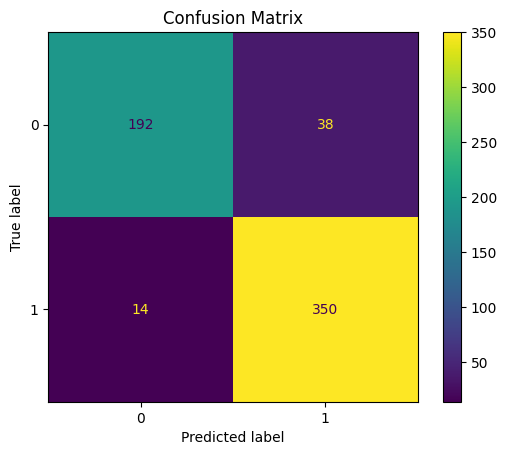

In [ ]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1,
                                 random_state=0, max_depth=9,
                                 min_samples_split=3, min_samples_leaf=2,
                                 max_features='log2')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

Model Accuracy: 0.914
Training Accuracy: 94.78%
Validation Accuracy: 91.41%
Test Accuracy: 90.57%


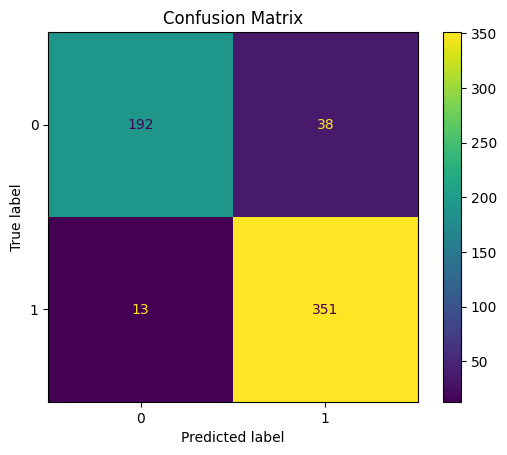

In [ ]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1,
                                 random_state=0, max_depth=9,
                                 min_samples_split=3, min_samples_leaf=2,
                                 max_features='sqrt')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

Model Accuracy: 0.911
Training Accuracy: 93.15%
Validation Accuracy: 91.08%
Test Accuracy: 89.23%


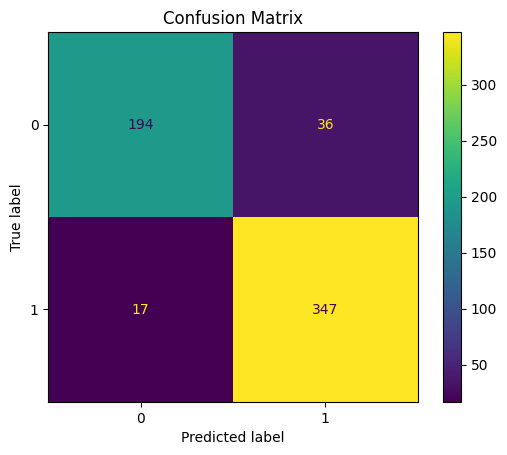

In [ ]:
rfc = RandomForestClassifier(n_estimators=750, n_jobs=-1,
                                 random_state=0, max_depth=12,
                                 min_samples_split=6, min_samples_leaf=4,
                                 max_features='log2')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

Model Accuracy: 0.914
Training Accuracy: 94.33%
Validation Accuracy: 91.41%
Test Accuracy: 90.40%


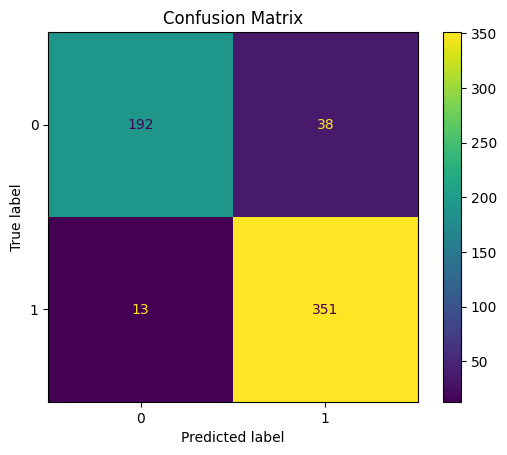

In [ ]:
rfc = RandomForestClassifier(n_estimators=750, n_jobs=-1,
                                 random_state=0, max_depth=12,
                                 min_samples_split=6, min_samples_leaf=4,
                                 max_features='sqrt')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

Model Accuracy: 0.916
Training Accuracy: 96.69%
Validation Accuracy: 91.58%
Test Accuracy: 90.74%


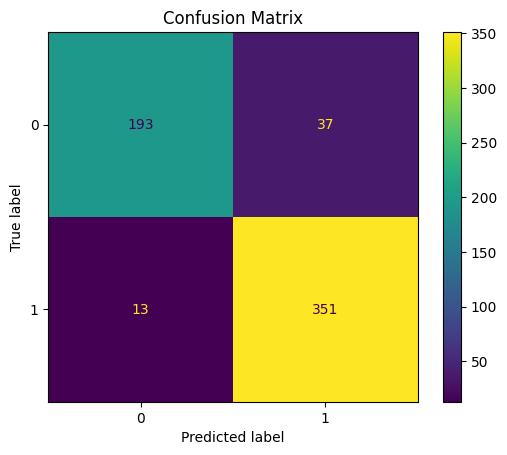

In [ ]:
rfc = RandomForestClassifier(n_estimators=750, n_jobs=-1,
                                 random_state=0, max_depth=20,
                                 min_samples_split=3, min_samples_leaf=2,
                                 max_features='sqrt')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

Model Accuracy: 0.914
Training Accuracy: 96.63%
Validation Accuracy: 91.41%
Test Accuracy: 90.57%


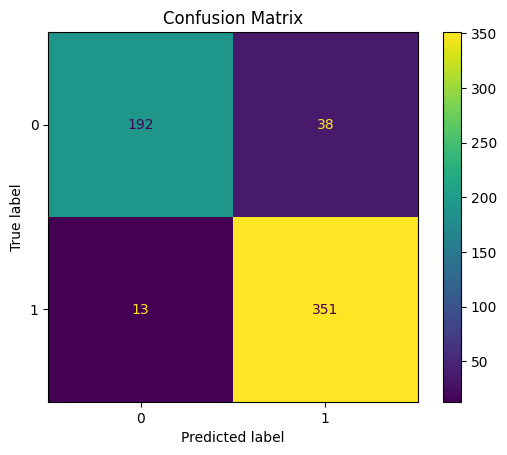

In [ ]:
rfc = RandomForestClassifier(n_estimators=1250, n_jobs=-1,
                                 random_state=0, max_depth=20,
                                 min_samples_split=3, min_samples_leaf=2,
                                 max_features='sqrt')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

Model Accuracy: 0.914
Training Accuracy: 94.05%
Validation Accuracy: 91.41%
Test Accuracy: 90.57%


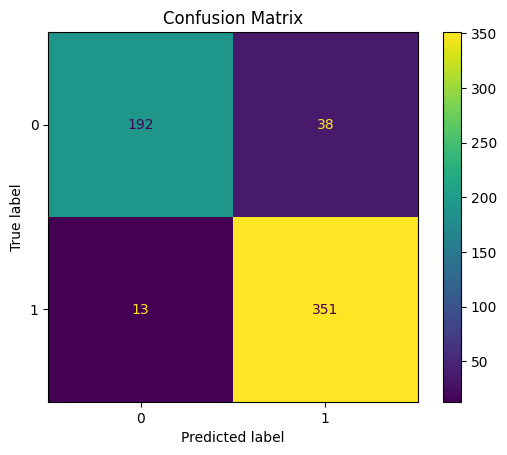

In [ ]:
rfc = RandomForestClassifier(n_estimators=750, n_jobs=-1,
                                 random_state=0, max_depth=20,
                                 min_samples_split=5, min_samples_leaf=5,
                                 max_features='sqrt')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

Model Accuracy: 0.916
Training Accuracy: 93.49%
Validation Accuracy: 91.58%
Test Accuracy: 90.74%


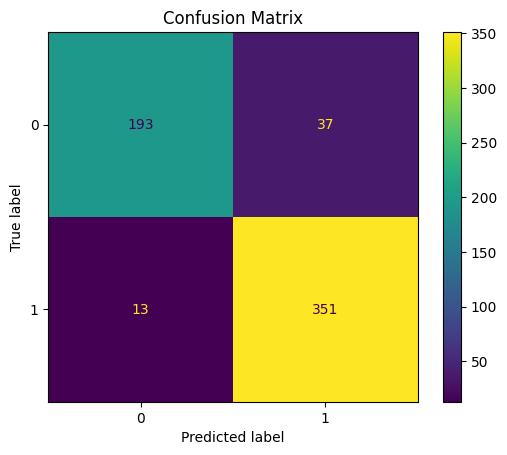

In [ ]:
rfc = RandomForestClassifier(n_estimators=750, n_jobs=-1,
                                 random_state=0, max_depth=25,
                                 min_samples_split=7, min_samples_leaf=7,
                                 max_features='sqrt')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

Model Accuracy: 0.914
Training Accuracy: 92.76%
Validation Accuracy: 91.41%
Test Accuracy: 90.40%


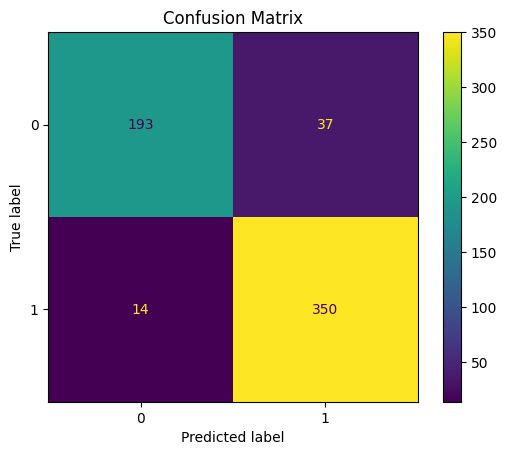

In [ ]:
rfc = RandomForestClassifier(n_estimators=750, n_jobs=-1,
                                 random_state=0, max_depth=30,
                                 min_samples_split=11, min_samples_leaf=11,
                                 max_features='sqrt')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

Model Accuracy: 0.918
Training Accuracy: 92.99%
Validation Accuracy: 91.75%
Test Accuracy: 90.40%


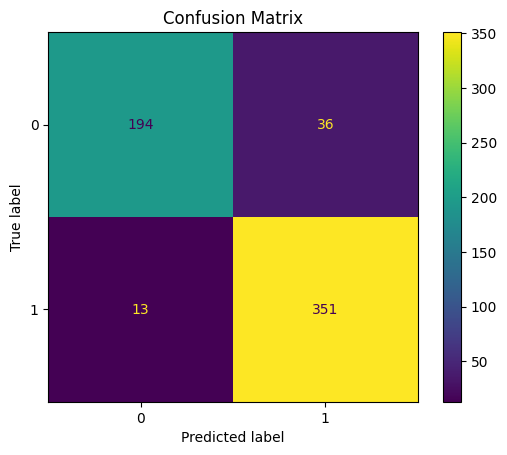

In [ ]:
rfc = RandomForestClassifier(n_estimators=750, n_jobs=-1,
                                 random_state=0, max_depth=27,
                                 min_samples_split=9, min_samples_leaf=9,
                                 max_features='sqrt')
rfc.fit(X_train, y_train)
print ("Model Accuracy:", round(rfc.score(X_val, y_val),3))

# Evaluate on training data
train_preds = rfc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Evaluate on validation data
val_preds = rfc.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

# Evaluate on test data
test_preds = rfc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_val_pred = rfc.predict(X_val)
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

##### Random Forest Experiments

Model# | Estimators | Max Depth| Min Sample Split | Min Sample Leaves | Max Features | Training Acc| Validation Acc | Test Acc
-|-|-|-|-|-|-|-|-
1 | 500 | 9 | 3 | 2 |'log2'| 93.43 | 91.25 | 89.39
2 | 500 | 9 | 3 | 2 |'sqrt'| 94.78 | 91.41 | 90.57
3 | 750 | 12 | 6 | 4 |'log2'| 93.15 | 91.08 | 89.23
4 | 750 | 12 | 6 | 4 |'sqrt'| 94.33 | 91.41 | 90.40
5 | 750 | 20 | 3 | 2 |'sqrt'| 96.69 | 91.58 | 90.74
6 | 1250 | 20 | 3 | 2 |'sqrt'| 96.63 | 91.41 | 90.57
7 | 750 | 20 | 5 | 5 |'sqrt'| 94.05 | 91.41 | 90.57
8 | 750 | 25 | 7 | 7 |'sqrt'| 93.49 | 91.58 | 90.74
9 | 750 | 30 | 11 | 11 |'sqrt'| 92.76 | 91.41 | 90.40
10 | 750 | 27 | 9 | 9 |'sqrt'| 92.99 | 91.75 | 90.40

##### Neural Network

In [ ]:
def build_model(num_features, learning_rate):
  """Build a TF Logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """

  tf.random.set_seed(1234)
  np.random.seed(1234)
  model = tf.keras.Sequential()

  # First hidden layer with ReLU activation
  model.add(tf.keras.layers.Dense(
      units=128,                         # Number of neurons
      input_shape=[num_features],       # Input dimension
      activation='relu',                # Activation function
      kernel_initializer='he_normal'    # He initialization for ReLU
  ))

  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='sigmoid',
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(
      loss='binary_crossentropy',
      optimizer=optimizer,
      metrics=[metrics.binary_accuracy])

  return model

  # Build Model
model_tf = build_model(num_features=X_train.shape[1], learning_rate=.1)

# Fit the model
fit_tf = model_tf.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_val,y_val),
      epochs=50,
      batch_size=12,
      verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test 1

In [ ]:
def build_model(num_features, learning_rate):
    """Build a TF Logistic regression model using Keras.

    Args:
      num_features: The number of input features.
      learning_rate: The desired learning rate for SGD.

    Returns:
      model: A tf.keras model (graph).
    """
    tf.random.set_seed(1234)
    np.random.seed(1234)
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(
        units=1,        # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
        activation='sigmoid',
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
    ))

    # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[metrics.binary_accuracy])

    return model

# Build Model
model_tf = build_model(num_features=X_train.shape[1], learning_rate=.1)

# Fit the model
fit_tf = model_tf.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_val,y_val),
      epochs=50,
      batch_size=12,
      verbose=0)

# Compute aggregated accuracy
print(f"Accuracy train data,\n {model_tf.evaluate(X_train, y_train, verbose=0)}")
print(f"Accuracy test data,\n {model_tf.evaluate(X_test, y_test, verbose=0)}\n")

Accuracy train data,
 [1.1321755647659302, 0.8821548819541931]
Accuracy test data,
 [1.7367297410964966, 0.8367003202438354]



Test 2

In [ ]:
def build_model(num_features, learning_rate):
    """Build a neural network model using Keras.

    Args:
      num_features: The number of input features.
      learning_rate: The desired learning rate for SGD.

    Returns:
      model: A tf.keras model (graph).
    """
    tf.random.set_seed(1234)
    np.random.seed(1234)
    model = tf.keras.Sequential()

    # First hidden layer with ReLU activation
    model.add(tf.keras.layers.Dense(
        units=64,                         # Number of neurons
        input_shape=[num_features],       # Input dimension
        activation='relu',                # Activation function
        kernel_initializer='he_normal'    # He initialization for ReLU
    ))


    model.add(tf.keras.layers.Dense(
        units=1,        # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
        activation='sigmoid',
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
    ))

    # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[metrics.binary_accuracy])

    return model

# Build Model
model_tf = build_model(num_features=X_train.shape[1], learning_rate=.1)

# Fit the model
fit_tf = model_tf.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_val,y_val),
      epochs=50,
      batch_size=12,
      verbose=0)

# Compute aggregated accuracy
print(f"Accuracy train data,\n {model_tf.evaluate(X_train, y_train, verbose=0)}")
print(f"Accuracy test data,\n {model_tf.evaluate(X_test, y_test, verbose=0)}\n")

Accuracy train data,
 [0.6678066849708557, 0.6122334599494934]
Accuracy test data,
 [0.6675856113433838, 0.6127946376800537]



Test 3

In [ ]:
def build_model(num_features, learning_rate):
    """Build a TF neural network model using Keras.

    Args:
      num_features: The number of input features.
      learning_rate: The desired learning rate for SGD.

    Returns:
      model: A tf.keras model (graph).
    """
    tf.random.set_seed(1234)
    np.random.seed(1234)
    model = tf.keras.Sequential()

    # First hidden layer with ReLU activation
    model.add(tf.keras.layers.Dense(
        units=64,                         # Number of neurons
        input_shape=[num_features],       # Input dimension
        activation='relu',                # Activation function
        kernel_initializer='he_normal'    # He initialization for ReLU
    ))

    # Second hidden layer with ReLU activation
    model.add(tf.keras.layers.Dense(
        units=32,                         # Number of neurons
        activation='relu',                # Activation function
        kernel_initializer='he_normal'    # He initialization for ReLU
    ))

    model.add(tf.keras.layers.Dense(
        units=1,        # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
        activation='sigmoid',
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
    ))

    # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[metrics.binary_accuracy])

    return model

# Build Model
model_tf = build_model(num_features=X_train.shape[1], learning_rate=.1)

# Fit the model
fit_tf = model_tf.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_val,y_val),
      epochs=50,
      batch_size=12,
      verbose=0)

# Compute aggregated accuracy
print(f"Accuracy train data,\n {model_tf.evaluate(X_train, y_train, verbose=0)}")
print(f"Accuracy test data,\n {model_tf.evaluate(X_test, y_test, verbose=0)}\n")

Accuracy train data,
 [0.6678066849708557, 0.6122334599494934]
Accuracy test data,
 [0.6675640940666199, 0.6127946376800537]



Test 4

In [ ]:
def build_model(num_features, learning_rate):
    """Build a TF Logistic regression model using Keras.

    Args:
      num_features: The number of input features.
      learning_rate: The desired learning rate for SGD.

    Returns:
      model: A tf.keras model (graph).
    """
    tf.random.set_seed(1234)
    np.random.seed(1234)
    model = tf.keras.Sequential()

    # First hidden layer with ReLU activation
    model.add(tf.keras.layers.Dense(
        units=128,                         # Number of neurons
        input_shape=[num_features],       # Input dimension
        activation='relu',                # Activation function
        kernel_initializer='he_normal'    # He initialization for ReLU
    ))

    model.add(tf.keras.layers.Dense(
        units=1,        # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
        activation='sigmoid',
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
    ))

    # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[metrics.binary_accuracy])

    return model

# Build Model
model_tf = build_model(num_features=X_train.shape[1], learning_rate=.1)

# Fit the model
fit_tf = model_tf.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_val,y_val),
      epochs=50,
      batch_size=12,
      verbose=0)

# Compute aggregated accuracy
print(f"Accuracy train data,\n {model_tf.evaluate(X_train, y_train, verbose=0)}")
print(f"Accuracy test data,\n {model_tf.evaluate(X_test, y_test, verbose=0)}\n")

Accuracy train data,
 [0.6678066849708557, 0.6122334599494934]
Accuracy test data,
 [0.6675640940666199, 0.6127946376800537]



Test 5

In [ ]:
def build_model(num_features, learning_rate):
    """Build a TF Logistic regression model using Keras.

    Args:
      num_features: The number of input features.
      learning_rate: The desired learning rate for SGD.

    Returns:
      model: A tf.keras model (graph).
    """
    tf.random.set_seed(1234)
    np.random.seed(1234)
    model = tf.keras.Sequential()

    # First hidden layer with ReLU activation
    model.add(tf.keras.layers.Dense(
        units=256,                         # Number of neurons
        input_shape=[num_features],       # Input dimension
        activation='relu',                # Activation function
        kernel_initializer='he_normal'    # He initialization for ReLU
    ))

    model.add(tf.keras.layers.Dense(
        units=1,        # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
        activation='sigmoid',
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
    ))

    # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[metrics.binary_accuracy])

    return model

# Build Model
model_tf = build_model(num_features=X_train.shape[1], learning_rate=.1)

# Fit the model
fit_tf = model_tf.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_val,y_val),
      epochs=50,
      batch_size=12,
      verbose=0)

# Compute aggregated accuracy
print(f"Accuracy train data,\n {model_tf.evaluate(X_train, y_train, verbose=0)}")
print(f"Accuracy test data,\n {model_tf.evaluate(X_test, y_test, verbose=0)}\n")

Accuracy train data,
 [0.6678066849708557, 0.6122334599494934]
Accuracy test data,
 [0.668263852596283, 0.6127946376800537]



Test 6

In [ ]:
# Fit the model
fit_tf = model_tf.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_val,y_val),
      epochs=50,
      batch_size=24,
      verbose=0)

# Compute aggregated accuracy
print(f"Accuracy train data,\n {model_tf.evaluate(X_train, y_train, verbose=0)}")
print(f"Accuracy test data,\n {model_tf.evaluate(X_test, y_test, verbose=0)}\n")

Accuracy train data,
 [0.6677398085594177, 0.6122334599494934]
Accuracy test data,
 [0.6681896448135376, 0.6127946376800537]



Test 7

In [ ]:
# Fit the model
fit_tf = model_tf.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_val,y_val),
      epochs=75,
      batch_size=64,
      verbose=0)

# Compute aggregated accuracy
print(f"Accuracy train data,\n {model_tf.evaluate(X_train, y_train, verbose=0)}")
print(f"Accuracy test data,\n {model_tf.evaluate(X_test, y_test, verbose=0)}\n")

Accuracy train data,
 [0.6677396297454834, 0.6122334599494934]
Accuracy test data,
 [0.6681895852088928, 0.6127946376800537]



Test 8

In [ ]:
# Fit the model
fit_tf = model_tf.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_val,y_val),
      epochs=65,
      batch_size=24,
      verbose=0)

# Compute aggregated accuracy
print(f"Accuracy train data,\n {model_tf.evaluate(X_train, y_train, verbose=0)}")
print(f"Accuracy test data,\n {model_tf.evaluate(X_test, y_test, verbose=0)}\n")

Accuracy train data,
 [0.6677398085594177, 0.6122334599494934]
Accuracy test data,
 [0.6681896448135376, 0.6127946376800537]

